In [1]:
from data_v2 import *
import numpy as np
import fnmatch
from mvar import *

In [2]:
stocks = ['WIKI/BAC', 'WIKI/GS', 'WIKI/MSFT', 'WIKI/JNJ']#, 'WIKI/ORCL', 'WIKI/NKE', 'WIKI/MCD', 'WIKI/HPQ',
#         'WIKI/JPM', 'WIKI/', 'WIKI/DIS', 'WIKI/WMT', 'WIKI/OXY', 'WIKI/T', 'WIKI/C']

models = {'ffnn_deterministic', 'ffnn_bayesian', 'lstm_deterministic', 'lstm_bayesian', 'gru_deterministic', 'gru_bayesian', 'tanh_deterministic', 'tanh_bayesian', 'relu_deterministic', 'relu_bayesian'}
models_justf = {'ffnn', 'lstm', 'gru', 'tanh', 'relu', 'var'}
time_period = {'daily', 'weekly', 'monthly', 'quarterly'}

n_steps = 7 #{7, 15, 30, 45}
#stocks = ['WIKI/BAC']

n_stocks = len(stocks)
batch_size = 100
#gamma = [0, 1, 20, 500]
bayes_iterations = 100

n_epochs = 3000



In [3]:
df =np.array(get_data(stocks= stocks, col = "daily"))
X,y = split_sequence(df, n_steps)
X_train, X_test, y_train, y_test = train_test(X,y, batch_size= batch_size)

KeyboardInterrupt: 

In [3]:
def test_dim(col):
    df =np.array(get_data(stocks= stocks, col = col))
    X,y = split_sequence(df, n_steps)
    X_train, X_test, y_train, y_test = train_test(X,y, batch_size= batch_size)
    return y_test.shape[0]

In [4]:
def just_data(stocks,col):
    df =np.array(get_data(stocks= stocks, col = col))
    X,y = split_sequence(df, n_steps)
    X_train, X_test, y_train, y_test = train_test(X,y, batch_size= batch_size)
    return X_test

In [5]:

n_stocks = len(stocks)


for period in time_period:
    var_hist = []
    X_test = just_data(stocks, period)
    for tstamp in range(X_test.shape[0]):
        var_hist.append(np.asmatrix(np.cov(X_test[tstamp, :, :], rowvar = False)))
        for mod in models_justf:
            path = './results/tp/' + str(period) + '_' + str(n_steps) + '_'
            np.savez(str(path + '_' + '_' + mod + '_deterministic_' + 'var'), var_hist)

###### MSE

In [6]:
from collections import defaultdict
import os

groups = defaultdict(list)

for filename in os.listdir('./results/tp/'):
    if fnmatch.fnmatch(filename, '*mse*'):
        basename, extension = os.path.splitext(filename)
        period, days, nista, stock, model, estimation, eval_ = basename.split('_')

        groups[period, model, estimation, eval_].append(filename)
        
mse_to_avg = []
for key, fnames in groups.items():
    mse_load = []
    for f in range(len(fnames)):
        val = np.load(str('./results/tp/' + fnames[f]))
        mse_load.append(val.f.arr_0)
    mse_to_avg.append((key[0:3], round(np.mean(mse_load),5)))

## Mean, Sigma

In [7]:
from collections import defaultdict
import tqdm


groups = defaultdict(list)

for filename in os.listdir('./results/tp/'):
    if fnmatch.fnmatch(filename, '*mu*'):
        basename, extension = os.path.splitext(filename)
        period, days, nista, stock, model, estimation, eval_ = basename.split('_')

        groups[period, model, estimation, eval_].append(filename)
        
y_hat = []
for key, fnames in tqdm.tqdm(groups.items()):
    mu_per_group = np.empty((test_dim(key[0]), n_stocks))
    kk = 0
    for f in range(len(fnames)):
        val = np.load(str('./results/tp/' + fnames[f]))
        mu_per_group[:,kk] = val.f.arr_0
        kk += 1
    y_hat.append(mu_per_group)
     

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [04:35<00:00,  5.47s/it]


In [8]:
from collections import defaultdict

groups = defaultdict(list)

for filename in os.listdir('./results/tp/'):
    if fnmatch.fnmatch(filename, '*var.npz'):
        basename, extension = os.path.splitext(filename)
        period, days, nista, stock, model, estimation, eval_ = basename.split('_')

        groups[period, model, estimation, eval_].append(filename)
        
sigma_hat = []
for key, fnames in tqdm.tqdm(groups.items()):
    if key[2] == 'deterministic':
        var_hist = np.load(str('./results/tp/' + key[0] + '_7___ffnn_deterministic_var.npz'))
        var_hist = var_hist.f.arr_0
        sigma_hat.append(var_hist)
    
    elif key[2] == 'bayesian':
        var_hist = np.load(str('./results/tp/' + key[0] + '_7___ffnn_deterministic_var.npz'))
        var_hist = var_hist.f.arr_0
        print(var_hist.shape)
        dim_test = test_dim(key[0])
        sigma_per_group = np.empty((dim_test, n_stocks))
        kk = 0
        covar_bayes = np.empty((dim_test, n_stocks, n_stocks))

        for fa in range(len(fnames)):
            val = np.load(str('./results/tp/' + fnames[fa]))
            sigma_per_group[:,kk] = val.f.arr_0
            kk += 1
        for m in range(dim_test):
            covar_bayes[m,:,:] = np.diag(sigma_per_group[m])
            np.fill_diagonal(var_hist[m], np.diag(covar_bayes[m]))

        sigma_hat.append(var_hist)
     

  0%|                                                                                           | 0/48 [00:00<?, ?it/s]

(866, 4, 4)


  2%|█▋                                                                                 | 1/48 [00:08<06:19,  8.08s/it]

(866, 4, 4)


  4%|███▍                                                                               | 2/48 [00:15<06:05,  7.94s/it]

(866, 4, 4)


  6%|█████▏                                                                             | 3/48 [00:23<05:55,  7.90s/it]

(866, 4, 4)


  8%|██████▉                                                                            | 4/48 [00:31<05:51,  7.98s/it]

(866, 4, 4)


 10%|████████▋                                                                          | 5/48 [00:39<05:40,  7.92s/it]

(866, 4, 4)


 12%|██████████▍                                                                        | 6/48 [00:46<05:27,  7.80s/it]

(40, 4, 4)


 27%|██████████████████████▏                                                           | 13/48 [00:51<03:18,  5.67s/it]

(40, 4, 4)


 29%|███████████████████████▉                                                          | 14/48 [00:56<03:00,  5.32s/it]

(40, 4, 4)


 31%|█████████████████████████▋                                                        | 15/48 [01:00<02:49,  5.14s/it]

(40, 4, 4)


 33%|███████████████████████████▎                                                      | 16/48 [01:05<02:33,  4.81s/it]

(40, 4, 4)


 35%|█████████████████████████████                                                     | 17/48 [01:09<02:24,  4.65s/it]

(40, 4, 4)


 38%|██████████████████████████████▊                                                   | 18/48 [01:13<02:15,  4.52s/it]

(13, 4, 4)


 52%|██████████████████████████████████████████▋                                       | 25/48 [01:17<01:17,  3.36s/it]

(13, 4, 4)


 54%|████████████████████████████████████████████▍                                     | 26/48 [01:22<01:21,  3.72s/it]

(13, 4, 4)


 56%|██████████████████████████████████████████████▏                                   | 27/48 [01:26<01:19,  3.80s/it]

(13, 4, 4)


 58%|███████████████████████████████████████████████▊                                  | 28/48 [01:30<01:20,  4.00s/it]

(13, 4, 4)


 60%|█████████████████████████████████████████████████▌                                | 29/48 [01:35<01:17,  4.10s/it]

(13, 4, 4)


 62%|███████████████████████████████████████████████████▎                              | 30/48 [01:40<01:18,  4.37s/it]

(179, 4, 4)


 77%|███████████████████████████████████████████████████████████████▏                  | 37/48 [01:45<00:36,  3.30s/it]

(179, 4, 4)


 79%|████████████████████████████████████████████████████████████████▉                 | 38/48 [01:51<00:38,  3.87s/it]

(179, 4, 4)


 81%|██████████████████████████████████████████████████████████████████▋               | 39/48 [01:55<00:37,  4.20s/it]

(179, 4, 4)


 83%|████████████████████████████████████████████████████████████████████▎             | 40/48 [02:01<00:36,  4.62s/it]

(179, 4, 4)


 85%|██████████████████████████████████████████████████████████████████████            | 41/48 [02:07<00:34,  4.98s/it]

(179, 4, 4)


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [02:12<00:00,  2.77s/it]


## It's important to make sure mu and sigma are consistent. Hence we look for to order indices in sigma_hat in the same way as in y_hat.

In [9]:
groups = defaultdict(list)

for filename in os.listdir('./results/tp/'):
    if fnmatch.fnmatch(filename, '*mu*'):
        basename, extension = os.path.splitext(filename)
        period, days, nista, stock, model, estimation, eval_ = basename.split('_')

        groups[period, model, estimation, eval_].append(filename)
        

mu_names = []
for key in groups.keys():
    mu_names.append(key[:3])

In [10]:
groups = defaultdict(list)

for filename in os.listdir('./results/tp/'):
    if fnmatch.fnmatch(filename, '*var.npz'):
        basename, extension = os.path.splitext(filename)
        period, days, nista, stock, model, estimation, eval_ = basename.split('_')

        groups[period, model, estimation, eval_].append(filename)


var_names = []
for key in groups.keys():
    var_names.append(key[:3])

In [11]:
idxs = []
for l in range(len(mu_names)):
    indices = [i for i, x in enumerate(var_names) if x == mu_names[l]]
    idxs.append(indices[0])

## Now that we have mus and sigmas we should run a loop and calculate portfolio weights

#### First step is to subset the the y_hat and sigma_hat in 4 sets representing the time period of calculation. Then we will get 4 sets, one for each panel in the graph.

### Daily

In [13]:
ind_1 = [i for i, x in enumerate(np.matrix(mu_names)[:,0]) if x == 'daily']
mu_1 = []
idxs_pick_1 = []

for ne in ind_1:
    mu_1.append(y_hat[ne])
    idxs_pick_1.append(idxs[ne])
    
    
    
sigma_1 = []
for ne in idxs_pick_1:
    sigma_1.append(sigma_hat[ne])
    

In [19]:
def log_likelihood(mean, sigma, data):
        sigma = np.sqrt(np.diagonal(sigma, axis1 = 1, axis2 = 2))
        s = (data - mean) ** 2 / (2 * (sigma ** 2))
        pdfs = np.exp(- s)
        pdfs /= np.sqrt(2 * np.pi) * sigma
        for i_row in range(len(pdfs)):
            for i_col in range(n_stocks):
                if pdfs[i_row,i_col] < 0.0000001:
                    pdfs[i_row,i_col] = 0.000004
        return np.nansum(np.log(pdfs))/len(data)

stocks = ['WIKI/BAC', 'WIKI/GS', 'WIKI/MSFT', 'WIKI/JNJ']
return_period = 'daily'

df =np.array(get_data(stocks= stocks, col = return_period))
X,y = split_sequence(df, n_steps = n_steps)
X_train, X_test, y_train, y_test = train_test(X,y, batch_size= batch_size)

log_lik_daily = []
for ne in range(len(mu_1)):
    log_lik_daily.append(log_likelihood(mu_1[ne].squeeze(), sigma_1[ne].squeeze(), y_test.squeeze()))
    
log_lik_daily

[9.80128390985074,
 10.86666205470524,
 -22.954307209949864,
 10.103817147081267,
 -30.26231877986341,
 10.567254962736442,
 -12.17458061475376,
 10.17595098408611,
 -15.412823883606693,
 10.852470751698528,
 -41.79795428841019,
 10.950379536480753]

In [21]:
for x in range(len(log_lik_daily)):
    print(round(log_lik_daily[x], 5))

9.80128
10.86666
-22.95431
10.10382
-30.26232
10.56725
-12.17458
10.17595
-15.41282
10.85247
-41.79795
10.95038


### Weekly

In [15]:
ind_2 = [i for i, x in enumerate(np.matrix(mu_names)[:,0]) if x == 'weekly']
mu_2 = []
idxs_pick_2 = []

for ne in ind_2:
    mu_2.append(y_hat[ne])
    idxs_pick_2.append(idxs[ne])
    
    
    
sigma_2 = []
for ne in idxs_pick_2:
    sigma_2.append(sigma_hat[ne])
    

In [16]:
return_period = 'weekly'

df =np.array(get_data(stocks= stocks, col = return_period))
X,y = split_sequence(df, n_steps = n_steps)
X_train, X_test, y_train, y_test = train_test(X,y, batch_size= batch_size)

log_lik_weekly = []
for ne in range(len(mu_2)):
    log_lik_weekly.append(log_likelihood(mu_2[ne].squeeze(), sigma_2[ne].squeeze(), y_test.squeeze()))

    
log_lik_weekly

[-16.716321191946882,
 7.11196832796189,
 7.616602779931505,
 6.660839277588221,
 6.285894035008501,
 6.844890757085965,
 7.444395513045977,
 4.007819779320839,
 7.709706884534877,
 7.456525489339937,
 2.5960003445217854,
 7.60531627828509]

### Monthly

In [17]:
ind_3 = [i for i, x in enumerate(np.matrix(mu_names)[:,0]) if x == 'monthly']
mu_3 = []
idxs_pick_3 = []

for ne in ind_3:
    mu_3.append(y_hat[ne])
    idxs_pick_3.append(idxs[ne])
    
    
    
sigma_3 = []
for ne in idxs_pick_3:
    sigma_3.append(sigma_hat[ne])
    

In [26]:
return_period = 'monthly'

df =np.array(get_data(stocks= stocks, col = return_period))
X,y = split_sequence(df, n_steps = n_steps)
X_train, X_test, y_train, y_test = train_test(X,y, batch_size= batch_size)

log_lik_monthly = []
for ne in range(len(mu_1)):
    log_lik_monthly.append(log_likelihood(mu_3[ne].squeeze(), sigma_3[ne].squeeze(), y_test.squeeze()))

    
log_lik_monthly

[-24.0799175684562,
 1.92936482410298,
 1.9469516898051187,
 -3.3802940830882777,
 1.9106850829198465,
 1.395010571523298,
 2.105150076476316,
 -0.6531227828714237,
 2.1657044128589726,
 3.2823740839162405,
 1.995753240247384,
 3.716994071831342]

### Quarterly

In [19]:
ind_4 = [i for i, x in enumerate(np.matrix(mu_names)[:,0]) if x == 'quarterly']
mu_4 = []
idxs_pick_4 = []

for ne in ind_4:
    mu_4.append(y_hat[ne])
    idxs_pick_4.append(idxs[ne])
    
    
    
sigma_4 = []
for ne in idxs_pick_4:
    sigma_4.append(sigma_hat[ne])
    


In [21]:
return_period = 'quarterly'

df =np.array(get_data(stocks= stocks, col = return_period))
X,y = split_sequence(df, n_steps = n_steps)
X_train, X_test, y_train, y_test = train_test(X,y, batch_size= batch_size)

log_lik_quarterly = []
for ne in range(len(mu_4)):
    log_lik_quarterly.append(log_likelihood(mu_4[ne].squeeze(), sigma_4[ne].squeeze(), y_test.squeeze()))

    
log_lik_quarterly

[-25.064126933821473,
 1.7303602114986192,
 -0.42758073501030724,
 -10.219781064016379,
 -0.3614892743720629,
 -10.88260230923154,
 -0.2872635474581521,
 1.0855421745510743,
 -0.3258019653990199,
 -4.19106859161127,
 -0.35014561903848407,
 1.7142746302076863]

In [29]:
for x in range(len(log_lik_daily)):
    print(round(log_lik_daily[x],4))

9.3542
10.2046
-inf
8.9181
-inf
9.8813
-inf
8.971
-inf
10.2197
-inf
10.3292


#### At last! Portfolio Optimization!

In [37]:
from mvar import *

stocks = ['WIKI/BAC', 'WIKI/GS', 'WIKI/MSFT', 'WIKI/JNJ']
return_period = 'daily'

df =np.array(get_data(stocks= stocks, col = return_period))
X,y = split_sequence(df, n_steps = n_steps)
X_train, X_test, y_train, y_test = train_test(X,y, batch_size= batch_size)


df = get_full_quandl_exp(stocks= stocks, col = return_period)
dates = np.asarray(df.tail(mu_1[0].shape[0]).index)

w0 = [1/mu_1[0].shape[1]] * mu_1[0].shape[1]
gamma = 1
#caluclate opt`mal portfolio weights given gamma
portfolio_1 = []
exprets_1 = []
pfvar_1 = []

for i_1 in range(len(mu_1)): 
    historical_weights = []    
    for ts in range(len(mu_1[i_1])):
        hv = mv_portfolio(returns = np.asmatrix(mu_1[i_1][ts]).T, variance = sigma_1[i_1][ts], mv_obj = mv_obj, w0 = w0, gamma = gamma)
        if not any(np.isnan(hv)):
            historical_weights.append(hv)
        else:
            historical_weights.append(historical_weights[ts - 1])
        

    #Predict the portfolio returns, and calculate expected returns and variance of portfolio

    value_per_position = [None] #* len(gamma) 
    portfolio_value = [None] #* len(gamma)
    
    value_per_position = [historical_weights[0] + historical_weights[0] * y_test[0].T]
    portfolio_value = [sum(value_per_position[0].T) - 1]

    for n in range(1,len(historical_weights)):
        value_per_position.append(value_per_position[n-1] + historical_weights[n] * y_test[n].T)
        portfolio_value.append(sum(value_per_position[n].T) - 1)
        
    portfolio_1.append(portfolio_value)
    
portfolio_1 = pd.DataFrame(np.asmatrix(np.asarray(portfolio_1)).T)
portfolio_1 = pd.DataFrame(portfolio_1).set_index(dates)


In [38]:
from benchmark_2 import *
stocks = ['WIKI/BAC', 'WIKI/GS', 'WIKI/MSFT', 'WIKI/JNJ']

port_hist = historical_portfolio_fun(stocks, n_steps, batch_size, 'daily', gamma)
portfolio_1 = portfolio_1.assign(hist=pd.Series(port_hist.squeeze()).values)
port_equal = equal_weights_fun(stocks, n_steps, batch_size, col = 'daily')
portfolio_1 = portfolio_1.assign(equal=pd.Series(port_equal.squeeze()).values)

4


In [39]:
from mvar import *

stocks = ['WIKI/BAC', 'WIKI/GS', 'WIKI/MSFT', 'WIKI/JNJ']
return_period = 'weekly'

df =np.array(get_data(stocks= stocks, col = return_period))
X,y = split_sequence(df, n_steps = n_steps)
X_train, X_test, y_train, y_test = train_test(X,y, batch_size= batch_size)

df = get_full_quandl_exp(stocks= stocks, col = return_period)
dates = np.asarray(df.tail(mu_2[0].shape[0]).index)

w0 = [1/mu_2[0].shape[1]] * mu_2[0].shape[1]
gamma = 1
#caluclate opt`mal portfolio weights given gamma
portfolio_2 = []
exprets_2 = []
pfvar_2 = []

for i_2 in range(len(mu_2)): 
    historical_weights = []    
    for ts in range(len(mu_2[i_2])):
        historical_weights.append(mv_portfolio(returns = np.asmatrix(mu_2[i_2][ts]).T, variance = sigma_2[i_2][ts], mv_obj = mv_obj, w0 = w0, gamma = gamma))
        

    #Predict the portfolio returns, and calculate expected returns and variance of portfolio

    value_per_position = [None] #* len(gamma) 
    portfolio_value = [None] #* len(gamma)

    expected_returns = [None] #* len(gamma) 
    portfolio_variance = [None] #* len(gamma) 

    
    value_per_position = [historical_weights[0] + historical_weights[0] * y_test[0].T]
    portfolio_value = [sum(value_per_position[0].T) - 1]

    expected_returns =  [np.asmatrix(historical_weights[0]) * np.asmatrix(mu_2[i_2][0]).T]
    portfolio_variance = [historical_weights[0].reshape(n_stocks,1).T * sigma_2[i_2][0] * historical_weights[0].reshape(n_stocks,1)]


    for n in range(1,len(historical_weights)):
        value_per_position.append(value_per_position[n-1] + historical_weights[n] * y_test[n].T)
        portfolio_value.append(sum(value_per_position[n].T) - 1)

        expected_returns.append(np.asmatrix(historical_weights[n]) * np.asmatrix(mu_2[i_2][n]).T)
        portfolio_variance.append(np.asmatrix(historical_weights[n].reshape(n_stocks,1).T) * np.asmatrix(sigma_2[i_2][n]) * np.asmatrix(historical_weights[n].reshape(n_stocks,1)))
        
    portfolio_2.append(portfolio_value)
    exprets_2.append(expected_returns)
    pfvar_2.append(portfolio_variance)
    
portfolio_2 = pd.DataFrame(np.asmatrix(np.asarray(portfolio_2)).T)
portfolio_2 = pd.DataFrame(portfolio_2).set_index(dates)
exprets_2 = pd.DataFrame(np.asmatrix(np.asarray(exprets_2)).T)
exprets_2 = pd.DataFrame(exprets_2).set_index(dates)
pfvar_2 = pd.DataFrame(np.asmatrix(np.asarray(pfvar_2)).T)
pfvar_2 = pd.DataFrame(pfvar_2).set_index(dates)


In [40]:
port_hist = historical_portfolio_fun(stocks, n_steps, batch_size, 'weekly', gamma)
portfolio_2 = portfolio_2.assign(hist=pd.Series(port_hist.squeeze()).values)
port_equal = equal_weights_fun(stocks, n_steps, batch_size, col = 'weekly')
portfolio_2 = portfolio_2.assign(equal=pd.Series(port_equal.squeeze()).values)

4


In [41]:
from mvar import *
stocks = ['WIKI/BAC', 'WIKI/GS', 'WIKI/MSFT', 'WIKI/JNJ']
return_period = 'monthly'

df =np.array(get_data(stocks= stocks, col = return_period))
X,y = split_sequence(df, n_steps = n_steps)
X_train, X_test, y_train, y_test = train_test(X,y, batch_size= batch_size)

df = get_full_quandl_exp(stocks= stocks, col = return_period)
dates = np.asarray(df.tail(mu_3[0].shape[0]).index)

w0 = [1/mu_3[0].shape[1]] * mu_3[0].shape[1]
gamma = 1
#caluclate opt`mal portfolio weights given gamma
portfolio_3 = []
exprets_3 = []
pfvar_3 = []

for i_3 in range(len(mu_3)): 
    historical_weights = []    
    for ts in range(len(mu_3[i_3])):
        hv = mv_portfolio(returns = np.asmatrix(mu_3[i_3][ts]).T, variance = sigma_3[i_3][ts], mv_obj = mv_obj, w0 = w0, gamma = gamma)
        if not any(np.isnan(hv)):
            historical_weights.append(hv)
        else:
            historical_weights.append(historical_weights[ts - 1])
        

    #Predict the portfolio returns, and calculate expected returns and variance of portfolio

    value_per_position = [None] #* len(gamma) 
    portfolio_value = [None] #* len(gamma)

    expected_returns = [None] #* len(gamma) 
    portfolio_variance = [None] #* len(gamma) 

    
    value_per_position = [historical_weights[0] + historical_weights[0] * y_test[0].T]
    portfolio_value = [sum(value_per_position[0].T) - 1]

    expected_returns =  [np.asmatrix(historical_weights[0]) * np.asmatrix(mu_3[i_3][0]).T]
    portfolio_variance = [historical_weights[0].reshape(n_stocks,1).T * sigma_3[i_3][0] * historical_weights[0].reshape(n_stocks,1)]


    for n in range(1,len(historical_weights)):
        value_per_position.append(value_per_position[n-1] + historical_weights[n] * y_test[n].T)
        portfolio_value.append(sum(value_per_position[n].T) - 1)

        expected_returns.append(np.asmatrix(historical_weights[n]) * np.asmatrix(mu_3[i_3][n]).T)
        portfolio_variance.append(np.asmatrix(historical_weights[n].reshape(n_stocks,1).T) * np.asmatrix(sigma_3[i_3][n]) * np.asmatrix(historical_weights[n].reshape(n_stocks,1)))
        
    portfolio_3.append(portfolio_value)
    exprets_3.append(expected_returns)
    pfvar_3.append(portfolio_variance)
    
portfolio_3 = pd.DataFrame(np.asmatrix(np.asarray(portfolio_3)).T)
portfolio_3 = pd.DataFrame(portfolio_3).set_index(dates)
exprets_3 = pd.DataFrame(np.asmatrix(np.asarray(exprets_3)).T)
exprets_3 = pd.DataFrame(exprets_3).set_index(dates)
pfvar_3 = pd.DataFrame(np.asmatrix(np.asarray(pfvar_3)).T)
pfvar_3 = pd.DataFrame(pfvar_3).set_index(dates)


In [42]:
port_hist = historical_portfolio_fun(stocks, n_steps, batch_size, 'monthly', gamma)
portfolio_3 = portfolio_3.assign(hist=pd.Series(port_hist.squeeze()).values)
port_equal = equal_weights_fun(stocks, n_steps, batch_size, col = 'monthly')
portfolio_3 = portfolio_3.assign(equal=pd.Series(port_equal.squeeze()).values)

4


In [43]:
from mvar import *

stocks = ['WIKI/BAC', 'WIKI/GS', 'WIKI/MSFT', 'WIKI/JNJ']
return_period = 'quarterly'

df =np.array(get_data(stocks= stocks, col = return_period))
X,y = split_sequence(df, n_steps = n_steps)
X_train, X_test, y_train, y_test = train_test(X,y, batch_size= batch_size)

df = get_full_quandl_exp(stocks= stocks, col = return_period)
dates = np.asarray(df.tail(mu_4[0].shape[0]).index)

w0 = [1/mu_4[0].shape[1]] * mu_4[0].shape[1]
gamma = 1
#caluclate opt`mal portfolio weights given gamma
portfolio_4 = []
exprets_4 = []
pfvar_4 = []

for i_4 in range(len(mu_4)): 
    historical_weights = []    
    for ts in range(len(mu_4[i_4])):
        historical_weights.append(mv_portfolio(returns = np.asmatrix(mu_4[i_4][ts]).T, variance = sigma_4[i_4][ts], mv_obj = mv_obj, w0 = w0, gamma = gamma))
        

    #Predict the portfolio returns, and calculate expected returns and variance of portfolio

    value_per_position = [None] #* len(gamma) 
    portfolio_value = [None] #* len(gamma)

    expected_returns = [None] #* len(gamma) 
    portfolio_variance = [None] #* len(gamma) 

    
    value_per_position = [historical_weights[0] + historical_weights[0] * y_test[0].T]
    portfolio_value = [sum(value_per_position[0].T) - 1]

    expected_returns =  [np.asmatrix(historical_weights[0]) * np.asmatrix(mu_4[i_4][0]).T]
    portfolio_variance = [historical_weights[0].reshape(n_stocks,1).T * sigma_4[i_4][0] * historical_weights[0].reshape(n_stocks,1)]


    for n in range(1,len(historical_weights)):
        value_per_position.append(value_per_position[n-1] + historical_weights[n] * y_test[n].T)
        portfolio_value.append(sum(value_per_position[n].T) - 1)

        expected_returns.append(np.asmatrix(historical_weights[n]) * np.asmatrix(mu_4[i_4][n]).T)
        portfolio_variance.append(np.asmatrix(historical_weights[n].reshape(n_stocks,1).T) * np.asmatrix(sigma_4[i_4][n]) * np.asmatrix(historical_weights[n].reshape(n_stocks,1)))
        
    portfolio_4.append(portfolio_value)
    exprets_4.append(expected_returns)
    pfvar_4.append(portfolio_variance)
    
portfolio_4 = pd.DataFrame(np.asmatrix(np.asarray(portfolio_4)).T)
portfolio_4 = pd.DataFrame(portfolio_4).set_index(dates)
exprets_4 = pd.DataFrame(np.asmatrix(np.asarray(exprets_4)).T)
exprets_4 = pd.DataFrame(exprets_4).set_index(dates)
pfvar_4 = pd.DataFrame(np.asmatrix(np.asarray(pfvar_4)).T)
pfvar_4 = pd.DataFrame(pfvar_4).set_index(dates)



In [44]:
port_hist = historical_portfolio_fun(stocks, n_steps, batch_size, 'quarterly', gamma)
portfolio_4 = portfolio_4.assign(hist=pd.Series(port_hist.squeeze()).values)
port_equal = equal_weights_fun(stocks, n_steps, batch_size, col = 'quarterly')
portfolio_4 = portfolio_4.assign(equal=pd.Series(port_equal.squeeze()).values)

4


### Time for some graph magic

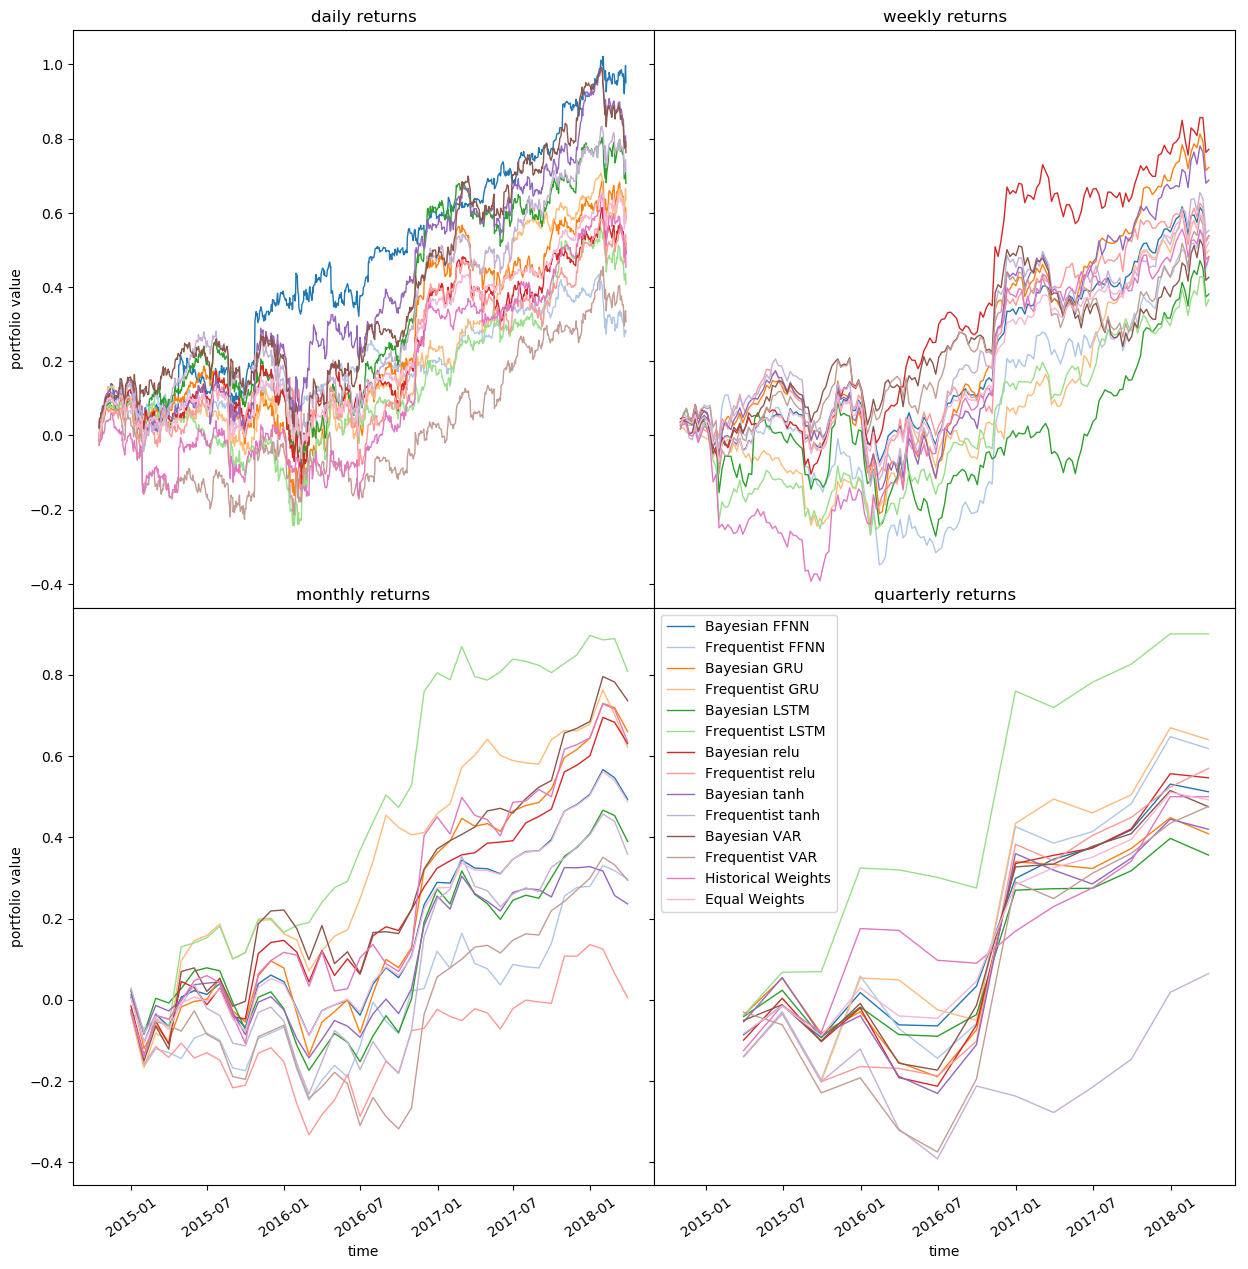

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

NUM_COLORS = 20

cm = plt.get_cmap('tab20')





plt.style.use('default')
plt.rc('lines', linewidth= 1.0)
#plt.style.use('fivethirtyeight')
fig, axs = plt.subplots(2, 2, figsize=(15,15), sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0, 'wspace': 0}, linewidth= 100)

#xfmt = mdates.DateFormatter('%Y-%m-%d')

(ax1, ax2), (ax3, ax4) = axs
#fig.suptitle('Sharing x per column, y per row')
ax1.set_prop_cycle(color = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
p1 = ax1.plot(portfolio_1)
ax1.set_title('daily returns')
#ax1.set_xticklabels([df.index[:100]])
ax2.set_prop_cycle(color = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
ax2.plot(portfolio_2)
ax2.set_title('weekly returns')
ax3.set_prop_cycle(color = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
ax3.plot(portfolio_3)
ax3.set_title('monthly returns')
ax4.set_prop_cycle(color = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

ax4.plot(portfolio_4)
ax4.set_title('quarterly returns')

for ax in axs.flat:
    ax.set(xlabel='time', ylabel='portfolio value')
    ax.label_outer()
    ax.xaxis.set_tick_params(rotation=35)
    


ax.legend((p1), ('Bayesian FFNN', 'Frequentist FFNN', 'Bayesian GRU', 'Frequentist GRU',
                'Bayesian LSTM', 'Frequentist LSTM', 'Bayesian relu', 'Frequentist relu',
                'Bayesian tanh', 'Frequentist tanh', 'Bayesian VAR', 'Frequentist VAR',
                'Historical Weights', 'Equal Weights'), loc='best', shadow=False)

# GAMMA 

In [46]:
gamma = [0,1,20,500]

In [49]:
from mvar import *
stocks = ['WIKI/BAC', 'WIKI/GS', 'WIKI/MSFT', 'WIKI/JNJ']
return_period = 'daily'

df =np.array(get_data(stocks= stocks, col = return_period))
X,y = split_sequence(df, n_steps = n_steps)
X_train, X_test, y_train, y_test = train_test(X,y, batch_size= batch_size)


df = get_full_quandl_exp(stocks= stocks, col = return_period)
dates = np.asarray(df.tail(mu_1[0].shape[0]).index)

w0 = [1/mu_1[0].shape[1]] * mu_1[0].shape[1]
#caluclate opt`mal portfolio weights given gamma
portfolio_1 = []
exprets_1 = []
pfvar_1 = []

for i_1 in range(len(mu_1)): 
    historical_weights = []    
    for ts in range(len(mu_1[i_1])):
        hv = mv_portfolio(returns = np.asmatrix(mu_1[i_1][ts]).T, variance = sigma_1[i_1][ts], mv_obj = mv_obj, w0 = w0, gamma = gamma[0])
        if not any(np.isnan(hv)):
            historical_weights.append(hv)
        else:
            historical_weights.append(historical_weights[ts - 1])
        

    #Predict the portfolio returns, and calculate expected returns and variance of portfolio

    value_per_position = [None] #* len(gamma) 
    portfolio_value = [None] #* len(gamma)

    expected_returns = [None] #* len(gamma) 
    portfolio_variance = [None] #* len(gamma) 

    
    value_per_position = [historical_weights[0] + historical_weights[0] * y_test[0].T]
    portfolio_value = [sum(value_per_position[0].T) - 1]

    expected_returns =  [np.asmatrix(historical_weights[0]) * np.asmatrix(mu_1[i_1][0]).T]
    portfolio_variance = [historical_weights[0].reshape(n_stocks,1).T * sigma_1[i_1][0] * historical_weights[0].reshape(n_stocks,1)]


    for n in range(1,len(historical_weights)):
        value_per_position.append(value_per_position[n-1] + historical_weights[n] * y_test[n].T)
        portfolio_value.append(sum(value_per_position[n].T) - 1)

        expected_returns.append(np.asmatrix(historical_weights[n]) * np.asmatrix(mu_1[i_1][n]).T)
        portfolio_variance.append(np.asmatrix(historical_weights[n].reshape(n_stocks,1).T) * np.asmatrix(sigma_1[i_1][n]) * np.asmatrix(historical_weights[n].reshape(n_stocks,1)))
        
    portfolio_1.append(portfolio_value)
    exprets_1.append(expected_returns)
    pfvar_1.append(portfolio_variance)
    
portfolio_1 = pd.DataFrame(np.asmatrix(np.asarray(portfolio_1)).T)
portfolio_1 = pd.DataFrame(portfolio_1).set_index(dates)
exprets_1 = pd.DataFrame(np.asmatrix(np.asarray(exprets_1)).T)
exprets_1 = pd.DataFrame(exprets_1).set_index(dates)
pfvar_1 = pd.DataFrame(np.asmatrix(np.asarray(pfvar_1)).T)
pfvar_1 = pd.DataFrame(pfvar_1).set_index(dates)


port_hist = historical_portfolio_fun(stocks, n_steps, batch_size, 'daily', gamma[0])
portfolio_1 = portfolio_1.assign(hist=pd.Series(port_hist.squeeze()).values)
port_equal = equal_weights_fun(stocks, n_steps, batch_size, col = 'daily')
portfolio_1 = portfolio_1.assign(equal=pd.Series(port_equal.squeeze()).values)

4


In [50]:
from mvar import *
stocks = ['WIKI/BAC', 'WIKI/GS', 'WIKI/MSFT', 'WIKI/JNJ']
return_period = 'daily'

df =np.array(get_data(stocks= stocks, col = return_period))
X,y = split_sequence(df, n_steps = n_steps)
X_train, X_test, y_train, y_test = train_test(X,y, batch_size= batch_size)


df = get_full_quandl_exp(stocks= stocks, col = return_period)
dates = np.asarray(df.tail(mu_1[0].shape[0]).index)

w0 = [1/mu_1[0].shape[1]] * mu_1[0].shape[1]
#caluclate opt`mal portfolio weights given gamma
portfolio_2 = []
exprets_1 = []
pfvar_1 = []

for i_1 in range(len(mu_1)): 
    historical_weights = []    
    for ts in range(len(mu_1[i_1])):
        hv = mv_portfolio(returns = np.asmatrix(mu_1[i_1][ts]).T, variance = sigma_1[i_1][ts], mv_obj = mv_obj, w0 = w0, gamma = gamma[1])
        if not any(np.isnan(hv)):
            historical_weights.append(hv)
        else:
            historical_weights.append(historical_weights[ts - 1])
        

    #Predict the portfolio returns, and calculate expected returns and variance of portfolio

    value_per_position = [None] #* len(gamma) 
    portfolio_value = [None] #* len(gamma)

    expected_returns = [None] #* len(gamma) 
    portfolio_variance = [None] #* len(gamma) 

    
    value_per_position = [historical_weights[0] + historical_weights[0] * y_test[0].T]
    portfolio_value = [sum(value_per_position[0].T) - 1]

    expected_returns =  [np.asmatrix(historical_weights[0]) * np.asmatrix(mu_1[i_1][0]).T]
    portfolio_variance = [historical_weights[0].reshape(n_stocks,1).T * sigma_1[i_1][0] * historical_weights[0].reshape(n_stocks,1)]


    for n in range(1,len(historical_weights)):
        value_per_position.append(value_per_position[n-1] + historical_weights[n] * y_test[n].T)
        portfolio_value.append(sum(value_per_position[n].T) - 1)

        expected_returns.append(np.asmatrix(historical_weights[n]) * np.asmatrix(mu_1[i_1][n]).T)
        portfolio_variance.append(np.asmatrix(historical_weights[n].reshape(n_stocks,1).T) * np.asmatrix(sigma_1[i_1][n]) * np.asmatrix(historical_weights[n].reshape(n_stocks,1)))
        
    portfolio_2.append(portfolio_value)
    exprets_1.append(expected_returns)
    pfvar_1.append(portfolio_variance)
    
portfolio_2 = pd.DataFrame(np.asmatrix(np.asarray(portfolio_2)).T)
portfolio_2 = pd.DataFrame(portfolio_2).set_index(dates)
exprets_1 = pd.DataFrame(np.asmatrix(np.asarray(exprets_1)).T)
exprets_1 = pd.DataFrame(exprets_1).set_index(dates)
pfvar_1 = pd.DataFrame(np.asmatrix(np.asarray(pfvar_1)).T)
pfvar_1 = pd.DataFrame(pfvar_1).set_index(dates)


port_hist = historical_portfolio_fun(stocks, n_steps, batch_size, 'daily', gamma[1])
portfolio_2 = portfolio_2.assign(hist=pd.Series(port_hist.squeeze()).values)
port_equal = equal_weights_fun(stocks, n_steps, batch_size, col = 'daily')
portfolio_2 = portfolio_2.assign(equal=pd.Series(port_equal.squeeze()).values)

4


In [51]:
from mvar import *
stocks = ['WIKI/BAC', 'WIKI/GS', 'WIKI/MSFT', 'WIKI/JNJ']
return_period = 'daily'

df =np.array(get_data(stocks= stocks, col = return_period))
X,y = split_sequence(df, n_steps = n_steps)
X_train, X_test, y_train, y_test = train_test(X,y, batch_size= batch_size)


df = get_full_quandl_exp(stocks= stocks, col = return_period)
dates = np.asarray(df.tail(mu_1[0].shape[0]).index)

w0 = [1/mu_1[0].shape[1]] * mu_1[0].shape[1]
#caluclate opt`mal portfolio weights given gamma
portfolio_3 = []
exprets_1 = []
pfvar_1 = []

for i_1 in range(len(mu_1)): 
    historical_weights = []    
    for ts in range(len(mu_1[i_1])):
        hv = mv_portfolio(returns = np.asmatrix(mu_1[i_1][ts]).T, variance = sigma_1[i_1][ts], mv_obj = mv_obj, w0 = w0, gamma = gamma[2])
        if not any(np.isnan(hv)):
            historical_weights.append(hv)
        else:
            historical_weights.append(historical_weights[ts - 1])
        

    #Predict the portfolio returns, and calculate expected returns and variance of portfolio

    value_per_position = [None] #* len(gamma) 
    portfolio_value = [None] #* len(gamma)

    expected_returns = [None] #* len(gamma) 
    portfolio_variance = [None] #* len(gamma) 

    
    value_per_position = [historical_weights[0] + historical_weights[0] * y_test[0].T]
    portfolio_value = [sum(value_per_position[0].T) - 1]

    expected_returns =  [np.asmatrix(historical_weights[0]) * np.asmatrix(mu_1[i_1][0]).T]
    portfolio_variance = [historical_weights[0].reshape(n_stocks,1).T * sigma_1[i_1][0] * historical_weights[0].reshape(n_stocks,1)]


    for n in range(1,len(historical_weights)):
        value_per_position.append(value_per_position[n-1] + historical_weights[n] * y_test[n].T)
        portfolio_value.append(sum(value_per_position[n].T) - 1)

        expected_returns.append(np.asmatrix(historical_weights[n]) * np.asmatrix(mu_1[i_1][n]).T)
        portfolio_variance.append(np.asmatrix(historical_weights[n].reshape(n_stocks,1).T) * np.asmatrix(sigma_1[i_1][n]) * np.asmatrix(historical_weights[n].reshape(n_stocks,1)))
        
    portfolio_3.append(portfolio_value)
    exprets_1.append(expected_returns)
    pfvar_1.append(portfolio_variance)
    
portfolio_3 = pd.DataFrame(np.asmatrix(np.asarray(portfolio_3)).T)
portfolio_3 = pd.DataFrame(portfolio_3).set_index(dates)
exprets_1 = pd.DataFrame(np.asmatrix(np.asarray(exprets_1)).T)
exprets_1 = pd.DataFrame(exprets_1).set_index(dates)
pfvar_1 = pd.DataFrame(np.asmatrix(np.asarray(pfvar_1)).T)
pfvar_1 = pd.DataFrame(pfvar_1).set_index(dates)


port_hist = historical_portfolio_fun(stocks, n_steps, batch_size, 'daily', gamma[2])
portfolio_3 = portfolio_3.assign(hist=pd.Series(port_hist.squeeze()).values)
port_equal = equal_weights_fun(stocks, n_steps, batch_size, col = 'daily')
portfolio_3 = portfolio_3.assign(equal=pd.Series(port_equal.squeeze()).values)

4


In [52]:
from mvar import *
stocks = ['WIKI/BAC', 'WIKI/GS', 'WIKI/MSFT', 'WIKI/JNJ']
return_period = 'daily'

df =np.array(get_data(stocks= stocks, col = return_period))
X,y = split_sequence(df, n_steps = n_steps)
X_train, X_test, y_train, y_test = train_test(X,y, batch_size= batch_size)


df = get_full_quandl_exp(stocks= stocks, col = return_period)
dates = np.asarray(df.tail(mu_1[0].shape[0]).index)

w0 = [1/mu_1[0].shape[1]] * mu_1[0].shape[1]
#caluclate opt`mal portfolio weights given gamma
portfolio_4 = []
exprets_1 = []
pfvar_1 = []

for i_1 in range(len(mu_1)): 
    historical_weights = []    
    for ts in range(len(mu_1[i_1])):
        hv = mv_portfolio(returns = np.asmatrix(mu_1[i_1][ts]).T, variance = sigma_1[i_1][ts], mv_obj = mv_obj, w0 = w0, gamma = gamma[3])
        if not any(np.isnan(hv)):
            historical_weights.append(hv)
        else:
            historical_weights.append(historical_weights[ts - 1])
        

    #Predict the portfolio returns, and calculate expected returns and variance of portfolio

    value_per_position = [None] #* len(gamma) 
    portfolio_value = [None] #* len(gamma)

    expected_returns = [None] #* len(gamma) 
    portfolio_variance = [None] #* len(gamma) 

    
    value_per_position = [historical_weights[0] + historical_weights[0] * y_test[0].T]
    portfolio_value = [sum(value_per_position[0].T) - 1]

    expected_returns =  [np.asmatrix(historical_weights[0]) * np.asmatrix(mu_1[i_1][0]).T]
    portfolio_variance = [historical_weights[0].reshape(n_stocks,1).T * sigma_1[i_1][0] * historical_weights[0].reshape(n_stocks,1)]


    for n in range(1,len(historical_weights)):
        value_per_position.append(value_per_position[n-1] + historical_weights[n] * y_test[n].T)
        portfolio_value.append(sum(value_per_position[n].T) - 1)

        expected_returns.append(np.asmatrix(historical_weights[n]) * np.asmatrix(mu_1[i_1][n]).T)
        portfolio_variance.append(np.asmatrix(historical_weights[n].reshape(n_stocks,1).T) * np.asmatrix(sigma_1[i_1][n]) * np.asmatrix(historical_weights[n].reshape(n_stocks,1)))
        
    portfolio_4.append(portfolio_value)
    exprets_1.append(expected_returns)
    pfvar_1.append(portfolio_variance)
    
portfolio_4 = pd.DataFrame(np.asmatrix(np.asarray(portfolio_4)).T)
portfolio_4 = pd.DataFrame(portfolio_4).set_index(dates)
exprets_1 = pd.DataFrame(np.asmatrix(np.asarray(exprets_1)).T)
exprets_1 = pd.DataFrame(exprets_1).set_index(dates)
pfvar_1 = pd.DataFrame(np.asmatrix(np.asarray(pfvar_1)).T)
pfvar_1 = pd.DataFrame(pfvar_1).set_index(dates)


port_hist = historical_portfolio_fun(stocks, n_steps, batch_size, 'daily', gamma[3])
portfolio_4 = portfolio_4.assign(hist=pd.Series(port_hist.squeeze()).values)
port_equal = equal_weights_fun(stocks, n_steps, batch_size, col = 'daily')
portfolio_4 = portfolio_4.assign(equal=pd.Series(port_equal.squeeze()).values)

4


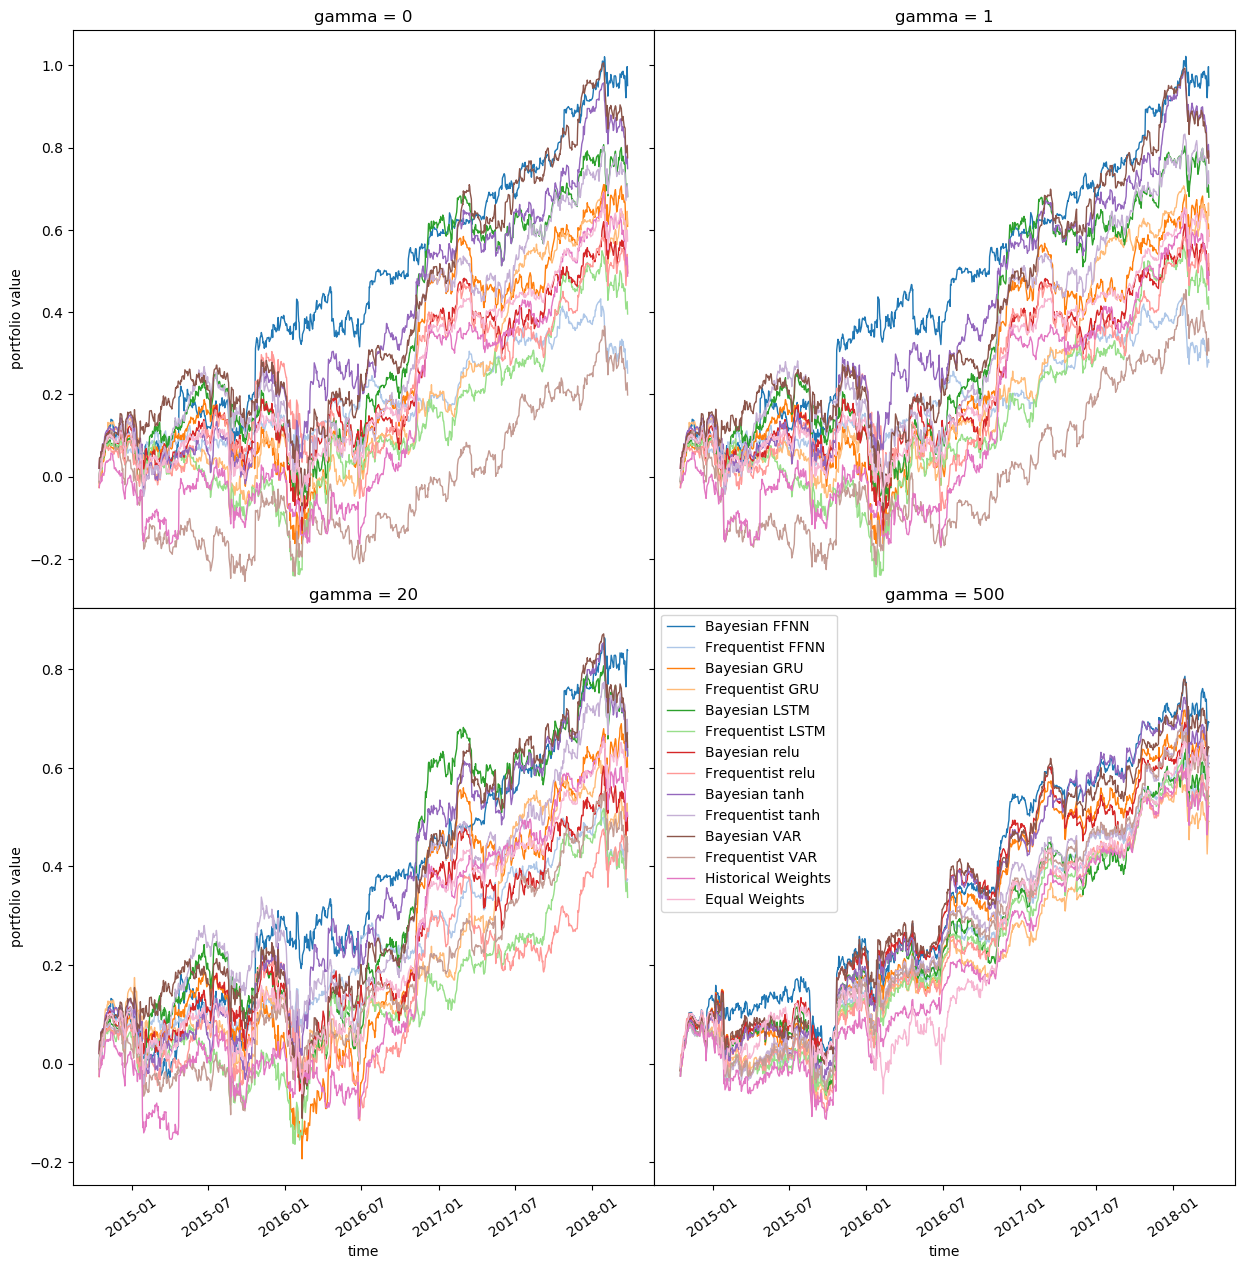

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline

NUM_COLORS = 20

cm = plt.get_cmap('tab20')


plt.style.use('default')
plt.rc('lines', linewidth= 1.0)
#plt.style.use('fivethirtyeight')
fig, axs = plt.subplots(2, 2, figsize=(15,15), sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0, 'wspace': 0}, linewidth= 100)

#xfmt = mdates.DateFormatter('%Y-%m-%d')

(ax1, ax2), (ax3, ax4) = axs
#fig.suptitle('Sharing x per column, y per row')
ax1.set_prop_cycle(color = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
p1 = ax1.plot(portfolio_1)
ax1.set_title('gamma = 0')
#ax1.set_xticklabels([df.index[:100]])
ax2.set_prop_cycle(color = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
ax2.plot(portfolio_2)
ax2.set_title('gamma = 1')
ax3.set_prop_cycle(color = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
ax3.plot(portfolio_3)
ax3.set_title('gamma = 20')
ax4.set_prop_cycle(color = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

ax4.plot(portfolio_4)
ax4.set_title('gamma = 500')

for ax in axs.flat:
    ax.set(xlabel='time', ylabel='portfolio value')
    ax.label_outer()
    ax.xaxis.set_tick_params(rotation=35)
    


ax.legend((p1), ('Bayesian FFNN', 'Frequentist FFNN', 'Bayesian GRU', 'Frequentist GRU',
                'Bayesian LSTM', 'Frequentist LSTM', 'Bayesian relu', 'Frequentist relu',
                'Bayesian tanh', 'Frequentist tanh', 'Bayesian VAR', 'Frequentist VAR',
                'Historical Weights', 'Equal Weights'), loc='best', shadow=False)